## Import

In [1]:
'''Toolboxs'''
import re
import cv2
import os
from os.path import join
import random
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

'''Tensorflow'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks as cb
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten,Activation,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB0


gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)

## Specify Dataset

In [2]:
DATA_DIR="../source"
all_classes = glob(DATA_DIR+'/*')
source_classes,val_classes=train_test_split(all_classes,test_size=0.3)
sorce_len=len(source_classes)
val_len=len(val_classes)
print(f"total {len(all_classes)} classes=source {sorce_len} + val {val_len} classes")

total 300 classes=source 210 + val 90 classes


## Set Image Loading+Pre-Processing

In [3]:
W,H,CH = 224,224,3
SUFFIX='.JPG'

def load_img(path, width = W):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=CH)/255
    img = img.numpy()
    
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2
    center_square = np.array([width,width])// 2
    new_size=(width,width)
    
    # cropping + resize
    img = img[oh:oh + shape_dst, ow:ow + shape_dst]
    img=cv2.resize(img, new_size)
    return tf.constant(img)


## Set Data Loading SPECs for Meta Learning

In [4]:
WAYS = 3
SHOTS=5
QUERIES=1
BATCH_SIZE=4

In [5]:
data_per_class=[len(glob(sdir+'/*.JPG')) for sdir in all_classes]
print("Min",min(data_per_class),",Max",max(data_per_class))

Min 10 ,Max 10


In [6]:
## exclude classes with too few examples
source_classes=[sdir for sdir in source_classes if len(glob(sdir+'/*.JPG'))>SHOTS+QUERIES]

sorce_len=len(source_classes)
print(f"source {sorce_len} + val {val_len} classes")

source 210 + val 90 classes


In [7]:
min([len(glob(sdir+'/*.JPG')) for sdir in source_classes])

10

## Form Loader function

In [8]:
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
'''Source Support'''
source_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*.JPG')), shuffle=True).map(map_fun).cache()
    for sc in source_classes
]
'''Source Query'''
source_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*.JPG')), shuffle=True).map(map_fun).cache()
    for sc in source_classes
]
'''Validation Support'''
val_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*.JPG')), shuffle=True).map(map_fun).cache()
    for sc in val_classes
]
'''Validation Query'''
val_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*.JPG')), shuffle=True).map(map_fun).cache()
    for sc in val_classes
]
def gen(sup_sub,q_sub):
    '''先決定好順序'''
    order=np.random.permutation(len(sup_sub))  
    '''For each task'''
    for tasks in range(len(sup_sub)//WAYS):
        '''從已決定好的順序拉出WAY個人'''
        picked_sup=[sup_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        picked_q=[q_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        '''support每個人各有SHOTS張照片'''
        support = tf.concat(
            [
                next(
                    iter(
                        sub.batch(SHOTS)
                    )
                    ) for sub in picked_sup
            ]
            , axis=0)
        '''query挑WAY人中的QUERY張，這邊是設定每張屬於不同人，順序不固定'''
        idxs=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = tf.concat(
            [
                next(
                    iter(
                        picked_q[idx].batch(1)
                    )
                    ) for idx in idxs
            ]
            , axis=0)
        '''輸出的時候把support跟query接在一起'''
        yield tf.concat([support, query], axis=0), tf.stack([keras.utils.to_categorical(idx,num_classes=WAYS) for idx in idxs], axis=0)


MLUT=2
data_source = tf.data.Dataset.from_generator(partial(gen,source_sup_sub,source_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(QUERIES,WAYS))
                                            ).prefetch(BATCH_SIZE).batch(BATCH_SIZE)
data_val = tf.data.Dataset.from_generator(partial(gen,val_sup_sub,val_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(QUERIES,WAYS))
                                            ).repeat(MLUT).prefetch(BATCH_SIZE).batch(BATCH_SIZE)

## Pre-run Loader

In [9]:
%%time
for sub in tqdm(source_sup_sub):
    for x in iter(sub.batch(10)):
        pass
for sub in tqdm(source_q_sub):
    for x in iter(sub.batch(10)):
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:18<00:00, 11.14it/s]

Wall time: 37.6 s


In [10]:
%%time
for sub in tqdm(val_sup_sub) :
    for x in iter(sub.batch(10)):
        pass
for sub in tqdm(val_q_sub) :
    for x in iter(sub.batch(10)):
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:08<00:00, 10.89it/s]

Wall time: 16.4 s


In [11]:
for val_x,val_y in data_val:
    break

Support 0


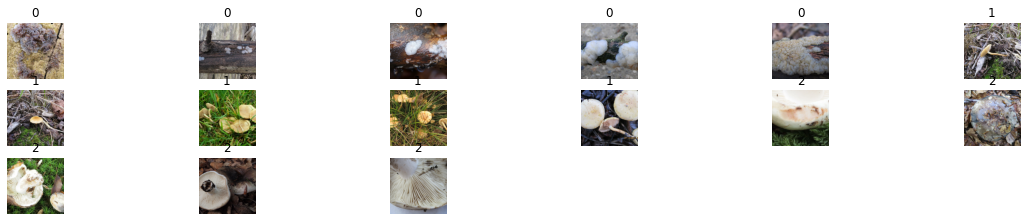

Query 0


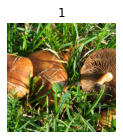

In [12]:
plt.figure(figsize=(20,6));ee=1
batch=1
print(f"Support 0")
for jj in range(WAYS*SHOTS):
    plt.subplot(SHOTS,WAYS*2,ee);plt.imshow(val_x[batch,jj,...],"gray")
    plt.title(f"{jj//SHOTS}");plt.axis("off");ee+=1
plt.show()
print("Query 0");plt.figure(figsize=(10,2));ee=1
for jj in range(QUERIES):
    plt.subplot(1,QUERIES,ee);plt.imshow(val_x[batch,WAYS*SHOTS+jj,...],"gray")
    plt.title(f"{val_y[batch,jj].numpy().argmax(-1)}");plt.axis("off");ee+=1
plt.show()

## Define sub-modules, functions for model

In [13]:
def conv_net(input_shape):
    convnet = Sequential()
    for i in range(4):
        convnet.add(Conv2D(128,(3,3),padding='valid',input_shape=input_shape))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    return convnet
def pretrain_net(input_shape):
    base_model = EfficientNetB0(weights="imagenet", include_top=False)
    x_in=Input(shape=(W,H,CH))
    x=preprocess_input(x_in)
    out=Flatten()(base_model(x))
    model = Model(inputs=x_in, outputs=out)
    return model
def euclidean_distance(f_1,f_2):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(f_1 - f_2), axis=-1))

## Define Forwarding Flow

In [14]:
base_dim = (W,H,CH)
# base_network = pretrain_net(base_dim)
base_network=conv_net(base_dim)
# Query feature
x_in=Input(shape=(WAYS*SHOTS+QUERIES,W,H,CH))
latent_s=[base_network(x_in[:,ii]) for ii in range(WAYS*SHOTS)]
latent_q=[base_network(x_in[:,WAYS*SHOTS+ii]) for ii in range(QUERIES)]

y=list()
for qq in range(QUERIES):
    dist_scores=list()
    for ww in range(WAYS):
        latent_proto=tf.reduce_mean(tf.stack(latent_s[ww*SHOTS:(ww+1)*SHOTS],axis=-1),axis=-1)
        dist_avg=euclidean_distance(latent_q[qq],latent_proto)
        dist_scores.append(dist_avg)
    y.append(tf.nn.softmax(-tf.stack(dist_scores,axis=-1),axis=-1))
y=tf.stack(y,axis=1)
    
model = Model(inputs=x_in, outputs=y)


## Compile model

In [15]:
lr=0.001
reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-8, verbose=1)
tensorboard = cb.TensorBoard(log_dir="tf_proto_logs")
earlystop=cb.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True, verbose=1)
opt = tf.keras.optimizers.Adam(lr=lr)
model.compile(loss=CategoricalCrossentropy(), optimizer=opt, metrics=['acc'])

## Training

In [16]:
EPOCHS=400
# %%time
try:
    model.fit(data_source,
              epochs=EPOCHS, 
              verbose=1,workers=4, 
              callbacks=[reduce_lr,earlystop, tensorboard],
              validation_data=data_source)
except KeyboardInterrupt:
    print("KeyboardInterrupt")

Epoch 1/400
      1/Unknown - 0s 0s/step - loss: 1.9494 - acc: 0.7500WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
      2/Unknown - 1s 319ms/step - loss: 2.4917 - acc: 0.7500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1792s vs `on_train_batch_end` time: 0.4596s). Check your callbacks.
18/18 [==============================] - 13s 698ms/step - loss: 2.0068 - acc: 0.7429 - val_loss: 2.6760 - val_acc: 0.6286
Epoch 2/400
18/18 [==============================] - 11s 607ms/step - loss: 2.3698 - acc: 0.6857 - val_loss: 2.7231 - val_acc: 0.7000
Epoch 3/400
18/18 [==============================] - 11s 607ms/step - loss: 2.0887 - acc: 0.7143 - val_loss: 3.0963 - val_acc: 0.6857
Epoc

In [17]:
model.save("cnn_proto.h5")

In [18]:
model.evaluate(data_val)

15/15 [==============================] - 3s 193ms/step - loss: 1.0709 - acc: 0.7833


[1.070942759513855, 0.7833333611488342]

In [19]:
EPOCHS=400
# %%time
try:
    model.fit(tf.data.Dataset.concatenate(data_source,data_val),
              epochs=EPOCHS, 
              verbose=1,workers=4, 
              callbacks=[reduce_lr,earlystop, tensorboard],
              validation_data=data_val)
except KeyboardInterrupt:
    print("KeyboardInterrupt")

Epoch 1/400
      2/Unknown - 1s 344ms/step - loss: 0.5088 - acc: 0.8750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2188s vs `on_train_batch_end` time: 0.4688s). Check your callbacks.
33/33 [==============================] - 17s 522ms/step - loss: 1.2913 - acc: 0.7154 - val_loss: 0.7334 - val_acc: 0.8167
Epoch 2/400
33/33 [==============================] - 17s 512ms/step - loss: 1.0911 - acc: 0.7154 - val_loss: 1.1531 - val_acc: 0.8000
Epoch 3/400
33/33 [==============================] - 17s 512ms/step - loss: 1.1289 - acc: 0.6846 - val_loss: 1.2784 - val_acc: 0.7333
Epoch 4/400
33/33 [==============================] - 17s 512ms/step - loss: 1.1687 - acc: 0.6846 - val_loss: 1.2269 - val_acc: 0.7000
Epoch 5/400
33/33 [==============================] - 17s 511ms/step - loss: 0.9718 - acc: 0.7154 - val_loss: 1.1269 - val_acc: 0.7667
Epoch 6/400
33/33 [==============================] - ETA: 0s - loss: 1.0627 - acc: 0.7692
Epoch

# Predict Meta Test set

In [23]:
import pandas as pd
test_set=pd.read_csv("../test2.csv")

In [24]:
TGT_SUP_DIR="../target_s"
test_classes=glob(join(TGT_SUP_DIR,"*"))

## Form Loader function

In [30]:
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
    
'''target Support Loaders'''
tgt_support_sub = [
    tf.data.Dataset.list_files(join(sc,'*.JPG'), shuffle=False).map(map_fun).cache().prefetch(5)
    for sc in test_classes
]
        
'''target Query Loader'''
query_fnames=test_set.filename.apply(lambda x: join("../target_q",x)).values
def yield_data(f_names,map_f):
    for fname in f_names:
        yield map_f(fname)
tgt_q_loader = tf.data.Dataset.from_generator(
        partial(yield_data,query_fnames,map_fun),
        output_types=tf.float32).cache().prefetch(8)

'''Encode classes'''
tst_list=[tst.split("\\")[-1] for tst in test_classes]
tgt_support_cls=[]
for all_sup in zip(test_set.support_0,test_set.support_1,test_set.support_2):
    tgt_support_cls.append([tst_list.index(clss) for clss in all_sup])

'''Task generator'''
def test_gen_(support_sub,query_loader,support_cls):
    for img_q,sup_cls in zip(query_loader,support_cls):
        support =  tf.concat(
                [
                    next(
                        iter(
                            support_sub[clss].batch(SHOTS)
                        )
                        ) for clss in sup_cls
                ], axis=0)
        query=tf.expand_dims(img_q,axis=0)
        yield tf.concat([support, query], axis=0)
        
data_test = tf.data.Dataset.from_generator(partial(test_gen_,tgt_support_sub,tgt_q_loader,tgt_support_cls),
                                    output_types=(tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH))).prefetch(8).batch(1)

In [31]:
%%time
for loader in tqdm(tgt_support_sub):
    for ii in loader:
        pass
for _ in tqdm(tgt_q_loader):
    pass

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.54it/s]
2200it [00:32, 67.45it/s]

Wall time: 38.3 s


In [32]:
%%time
pred=model.predict(data_test,verbose=True).squeeze().argmax(-1)

      1/Unknown - 0s 0s/stepWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0100s vs `on_predict_batch_end` time: 0.0270s). Check your callbacks.
2200/2200 [==============================] - 88s 40ms/step
Wall time: 1min 29s


In [33]:
pred_pd=test_set.copy()
pred_pd.drop(columns=["support_0","support_1","support_2"],inplace=True)
pred_pd["ans"]=pred
pred_pd.to_csv("pred_cnn_proto.csv",index=False)